In [1]:
%matplotlib inline
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

In [40]:
# https://github.com/hindupuravinash/the-gan-zoo
    
# 데이터 https://www.kaggle.com/zalando-research/fashionmnist
    
class FashionMNIST(Dataset):
    def __init__(self, transform=None):
        self.transform = transform
        fashion_df = pd.read_csv('data/fashionmnist/fashion-mnist_train.csv')
        self.labels = fashion_df.label.values
        self.images = fashion_df.iloc[:, 1:].values.astype('uint8').reshape(-1, 28, 28)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        label = self.labels[idx]
        img = Image.fromarray(self.images[idx])
        
        if self.transform:
            img = self.transform(img)

        return img, label

In [41]:
dataset = FashionMNIST()
dataset[0][0]

In [42]:
transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
])
dataset = FashionMNIST(transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=64, shuffle=True)

In [11]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(794, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(x.size(0), 784)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

In [12]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.label_emb = nn.Embedding(10, 10)
        
        self.model = nn.Sequential(
            nn.Linear(110, 256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(256, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 784),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(z.size(0), 100)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(x.size(0), 28, 28)

In [13]:
generator = Generator().cuda()
discriminator = Discriminator().cuda()

In [14]:
criterion = nn.MSELoss()
d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=1e-4)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)

In [34]:
def generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion):
    g_optimizer.zero_grad()
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    validity = discriminator(fake_images, fake_labels)
    g_loss = criterion(validity, Variable(torch.ones(batch_size)).cuda())
    g_loss.backward()
    g_optimizer.step()
    return g_loss.data.cpu()

In [32]:
def discriminator_train_step(batch_size, discriminator, generator, d_optimizer, criterion, real_images, labels):
    d_optimizer.zero_grad()

    # train with real images
    real_validity = discriminator(real_images, labels)
    real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).cuda())
    
    # train with fake images
    z = Variable(torch.randn(batch_size, 100)).cuda()
    fake_labels = Variable(torch.LongTensor(np.random.randint(0, 10, batch_size))).cuda()
    fake_images = generator(z, fake_labels)
    fake_validity = discriminator(fake_images, fake_labels)
    fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).cuda())
    
    d_loss = real_loss + fake_loss
    d_loss.backward()
    d_optimizer.step()
    return d_loss.data.cpu()

Starting epoch 0...
g_loss: 0.8971698880195618, d_loss: 0.05490584671497345


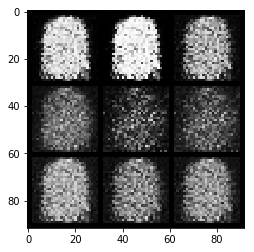

Starting epoch 1...
g_loss: 0.9509324431419373, d_loss: 0.09944514185190201


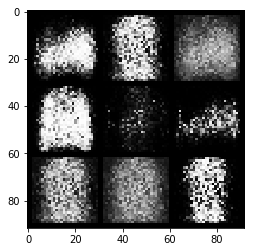

Starting epoch 2...
g_loss: 0.9095519185066223, d_loss: 0.05967406928539276


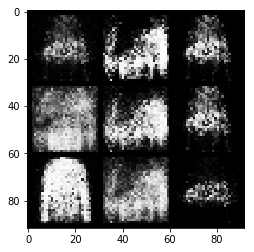

Starting epoch 3...
g_loss: 0.9478375911712646, d_loss: 0.155291348695755


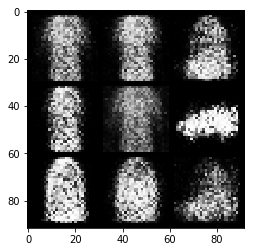

Starting epoch 4...
g_loss: 0.7246172428131104, d_loss: 0.2868107855319977


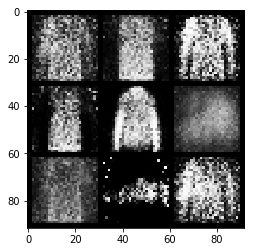

Starting epoch 5...
g_loss: 0.8105471730232239, d_loss: 0.28555935621261597


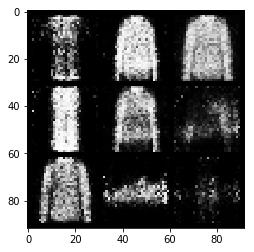

Starting epoch 6...
g_loss: 0.7184585928916931, d_loss: 0.3147105276584625


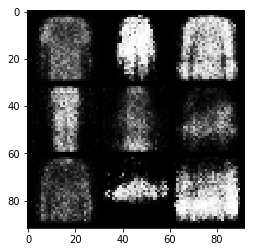

Starting epoch 7...
g_loss: 0.6298549771308899, d_loss: 0.39984115958213806


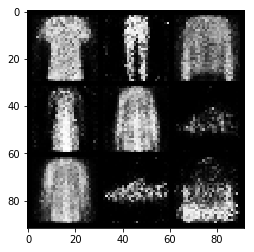

Starting epoch 8...
g_loss: 0.412130206823349, d_loss: 0.24458253383636475


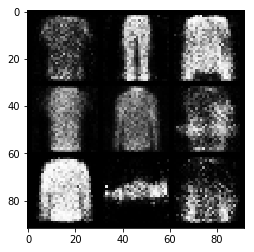

Starting epoch 9...
g_loss: 0.6036658883094788, d_loss: 0.21549281477928162


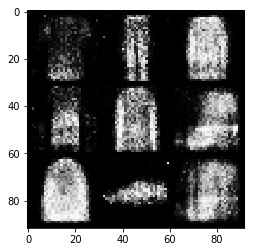

Starting epoch 10...
g_loss: 0.5792571306228638, d_loss: 0.40470075607299805


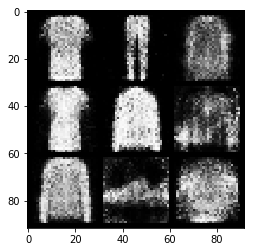

Starting epoch 11...
g_loss: 0.5431525707244873, d_loss: 0.2621079087257385


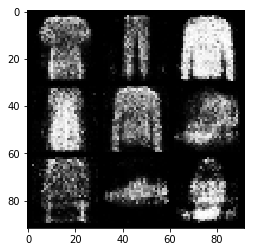

Starting epoch 12...
g_loss: 0.6615590453147888, d_loss: 0.2678406536579132


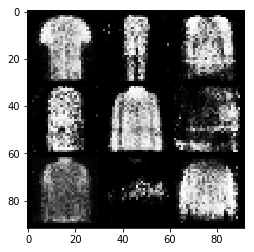

Starting epoch 13...
g_loss: 0.5379247069358826, d_loss: 0.34474968910217285


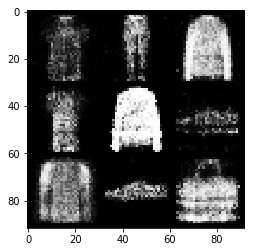

Starting epoch 14...
g_loss: 0.579709529876709, d_loss: 0.3083580732345581


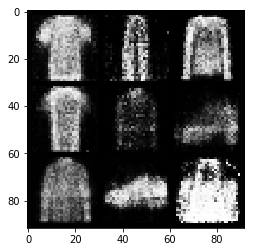

Starting epoch 15...
g_loss: 0.517015814781189, d_loss: 0.37331312894821167


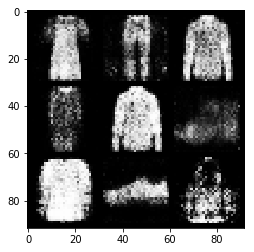

Starting epoch 16...
g_loss: 0.5586941242218018, d_loss: 0.33228111267089844


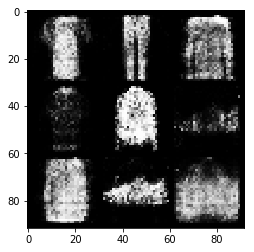

Starting epoch 17...
g_loss: 0.478035569190979, d_loss: 0.31936272978782654


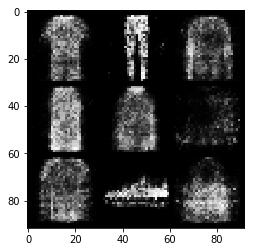

Starting epoch 18...
g_loss: 0.5128042101860046, d_loss: 0.32425594329833984


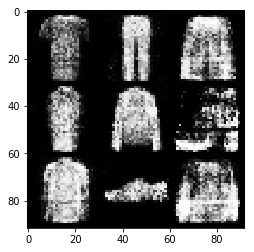

Starting epoch 19...
g_loss: 0.5268059968948364, d_loss: 0.27468419075012207


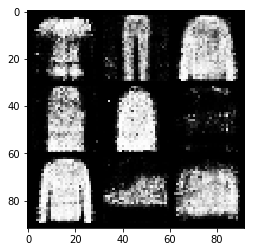

Starting epoch 20...
g_loss: 0.5363562107086182, d_loss: 0.2370515614748001


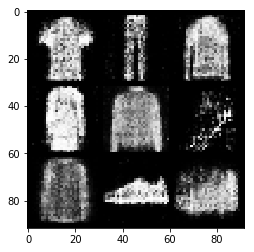

Starting epoch 21...
g_loss: 0.5117490291595459, d_loss: 0.3656190037727356


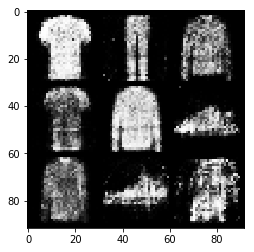

Starting epoch 22...
g_loss: 0.4889169931411743, d_loss: 0.48925501108169556


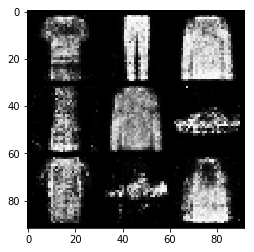

Starting epoch 23...
g_loss: 0.4102790355682373, d_loss: 0.32265961170196533


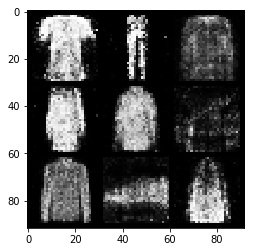

Starting epoch 24...
g_loss: 0.4207931458950043, d_loss: 0.36203163862228394


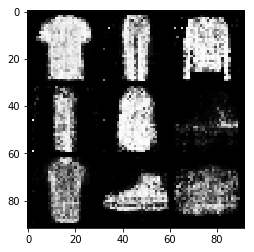

Starting epoch 25...
g_loss: 0.5540655255317688, d_loss: 0.39427441358566284


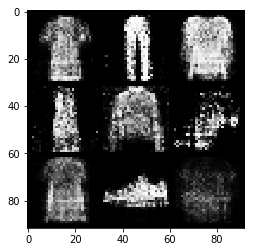

Starting epoch 26...
g_loss: 0.40490132570266724, d_loss: 0.37695151567459106


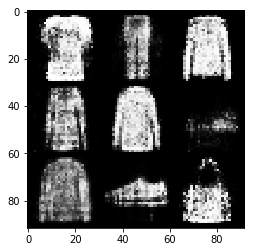

Starting epoch 27...
g_loss: 0.43080711364746094, d_loss: 0.32624247670173645


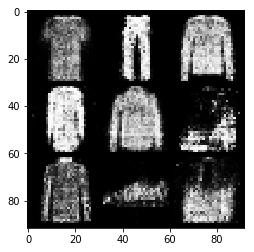

Starting epoch 28...
g_loss: 0.3900524377822876, d_loss: 0.3720420002937317


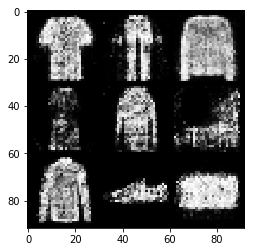

Starting epoch 29...
g_loss: 0.40538299083709717, d_loss: 0.39633676409721375


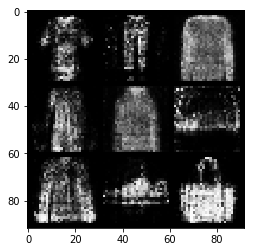

In [35]:
num_epochs = 30
n_critic = 5
display_step = 300
for epoch in range(num_epochs):
    print('Starting epoch {}...'.format(epoch))
    for i, (images, labels) in enumerate(data_loader):
        real_images = Variable(images).cuda()
        labels = Variable(labels).cuda()
        generator.train()
        batch_size = real_images.size(0)
        d_loss = discriminator_train_step(len(real_images), discriminator,
                                          generator, d_optimizer, criterion,
                                          real_images, labels)
        

        g_loss = generator_train_step(batch_size, discriminator, generator, g_optimizer, criterion)

    generator.eval()
    print('g_loss: {}, d_loss: {}'.format(g_loss, d_loss))
    z = Variable(torch.randn(9, 100)).cuda()
    labels = Variable(torch.LongTensor(np.arange(9))).cuda()
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.show()

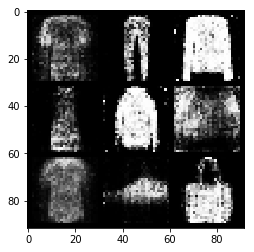

In [52]:
z = Variable(torch.randn(9, 100)).cuda()
z
labels = Variable(torch.LongTensor(np.arange(9))).cuda()
labels
sample_images = generator(z, labels).unsqueeze(1).data.cpu()
grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
plt.imshow(grid)
plt.show()